In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'google.colab'

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sshikamaru/car-object-detection

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection
License(s): other
100% 112M/112M [00:06<00:00, 20.9MB/s]
100% 112M/112M [00:06<00:00, 17.6MB/s]


In [3]:
!unzip "/content/car-object-detection.zip"

Archive:  /content/car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/vid_5_26660.jp

In [42]:
import os
from tqdm import tqdm
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from torchvision import models
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display
from torchvision.ops import box_iou
from torchvision import transforms as T
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights


EPOCH = 5
CONF_TRESHOLD = 0.20

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [43]:
class CustDat(torch.utils.data.Dataset):
  def __init__(self, df, unique_imgs, indices):
    self.df = df
    self.unique_imgs = unique_imgs
    self.indices= indices

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):
    image_name= self.unique_imgs[self.indices[idx]]
    boxes= self.df[self.df.image == image_name].values[:, 1:].astype("float")
    img = Image.open("/content/data/training_images/" + image_name ).convert('RGB')
    labels = torch.ones((boxes.shape[0]), dtype = torch.int64)
    target ={}
    target["boxes"] = torch.tensor (boxes)
    target["labels"] = labels
    return T.ToTensor() (img), target

In [44]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights= 'FasterRCNN_ResNet50_FPN_Weights.COCO_V1')


num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [45]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        pass
    return T.Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))
def custom_collate(data):
  return data

In [46]:
dataset= pd.read_csv("/content/data/train_solution_bounding_boxes (1).csv")

unique_imgs=dataset.image.unique()

train_inds,test_inds=train_test_split(range(unique_imgs.shape[0]),test_size=0.1)

train_dl=torch.utils.data.DataLoader(CustDat(dataset,unique_imgs,train_inds),
                                     batch_size=8,
                                     shuffle=True,
                                     collate_fn=custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False)

test_dl=torch.utils.data.DataLoader(CustDat(dataset,unique_imgs,test_inds),
                                     batch_size=8,
                                     shuffle=True,
                                     collate_fn=custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False)

In [47]:
len(train_dl)

40

In [48]:
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]

optimizer= torch.optim.SGD(
    params,
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)

In [49]:
print(f"Start training on {device} [...]")

def train_epoch(model, optimizer, data_loader, device, epoch):
        model.train()
        epoch_loss = 0
        for data in (tepoch :=tqdm(data_loader)):
            tepoch.set_description(f"Epoch {epoch}")

            imgs = list(d[0].to(device) for d in data) 
            targets = [{boxes: labels.to(device) for boxes, labels in d[1].items()} for d in data] 


            loss_dict = model(imgs, targets)
            loss = sum(v for v in loss_dict.values())


            epoch_loss += loss.cpu().detach().numpy()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            tepoch.set_postfix(epoch_loss=epoch_loss.item())


            del loss
            torch.cuda.empty_cache()

for epochs in range (EPOCH):
    train_epoch(model, optimizer, train_dl, device, epochs)
    lr_scheduler.step()

Start training on cuda [...]


Epoch 4: 100%|██████████| 40/40 [01:30<00:00,  2.27s/it, epoch_loss=4.6]


In [50]:
torch.cuda.empty_cache()

In [51]:
def compute_ap(gt_boxes, gt_labels, pred_boxes, pred_scores, iou_threshold=0.40, class_label=1, device='cpu'):

    sort_idx = torch.argsort(pred_scores, descending=True)
    pred_boxes = pred_boxes[sort_idx]
    pred_scores = pred_scores[sort_idx]
    print(gt_labels)

    iou = box_iou(pred_boxes, gt_boxes)
    print(iou)

    match_idx = iou.argmax(dim=1)
    print(match_idx)
    match_iou = iou[range(iou.shape[0]), match_idx]
    print(match_iou)

    tp = torch.zeros_like(pred_scores)
    fp = torch.zeros_like(pred_scores)

    matched = torch.zeros(match_iou.shape[0], dtype=torch.bool)

    true_labels = []
    predicted_labels = []
    threshold=0.55

    for i in range(pred_scores.shape[0]):
        if match_iou[i] >= iou_threshold:
            if not matched[match_idx[i]]:
                tp[i] = 1
                matched[match_idx[i]] = True
            else:
                fp[i] = 1
        else:
            fp[i] = 1
        true_labels = [1 if condition else 0 for condition in matched]
        predicted_labels.append(int(pred_scores[i] > threshold))

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    tp_cumsum = torch.sum(tp).item()
    fp_cumsum = torch.sum(fp).item()
    fn_cumsum = gt_boxes.shape[0] - tp_cumsum 

    precision = tp_cumsum / (tp_cumsum + fp_cumsum)
    ap = average_precision_score(true_labels, predicted_labels)


    print("Precision:", precision)
    print("Average precision:", ap)

    return ap,precision


In [52]:
model.eval()
# data=iter(test_dl).__next__()
# disp_imgs(test_dl)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [53]:
def disp_imgs(dl):
    precision_list = []
    ap_list = []
    for data in dl:
        length = len(data)
        i=0
        for i in range(len(data)):
            imgs = data[i][0]
            targets = data[i][1]
            boxes = targets['boxes']
            boxes = boxes.type(torch.int)
            labels = targets['labels']
            i+=1

            output = model([imgs.to(device)])
            out_bbox = output[0]["boxes"]
            out_scores = output[0]["scores"]


            confidence_keep = out_scores >= CONF_TRESHOLD
            out_bbox = out_bbox[confidence_keep]
            out_scores = out_scores[confidence_keep]

            keep = torchvision.ops.nms(out_bbox, out_scores, 0.40)

            im = (imgs.permute(1, 2, 0).cpu().detach().numpy() * 255).astype('uint8')
            vsample = Image.fromarray(im)
            draw = ImageDraw.Draw(vsample)

            for box, score in zip(out_bbox[keep],out_scores[keep]):  
                draw.rectangle(list(box), fill=None, outline="red")
                draw.text((box[0], box[1]), f"Conf: {score:.2f}", fill="white")
            for box in boxes:       
                draw.rectangle(list(box), fill=None, outline="green")
            display(vsample)

            result  = compute_ap(boxes.to(device), labels.to(device), out_bbox[keep].to(device), out_scores[keep].to(device), class_label=1, device=device)

            ap, precision = result[0], result[1]
            precision_list.append(precision)
            ap_list.append(ap)

    print("precision_mean: ", np.mean(precision_list))
    print("ap_mean: " , np.mean(ap_list))

In [54]:
import glob
jpgfiles = []
for file in glob.glob("/content/data/testing_images/*.jpg"):
    jpgfiles.append(file)

In [55]:
test_imgs = []
for j in range(len(jpgfiles)):
    test_img = Image.open(jpgfiles[j]).convert('RGB')
    test_img = T.ToTensor()(test_img)
    test_imgs.append(test_img)


In [56]:
print(len(test_imgs[:10]))

10


In [57]:
def disp_test_imgs(dl):
    for k in range(len(dl)):
        output = model([dl[k].to(device)])
        out_bbox = output[0]["boxes"]
        out_scores = output[0]["scores"]
        keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)
        im = (dl[k].permute(1, 2, 0).cpu().detach().numpy() * 255).astype('uint8')
        vtest = Image.fromarray(im)
        draw = ImageDraw.Draw(vtest)
        for box, score in zip(out_bbox[keep],out_scores[keep]):  
                draw.rectangle(list(box), fill=None, outline="red")
                draw.text((box[0], box[1]), f"Conf: {score:.2f}", fill="white")
        display(vtest)

In [27]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

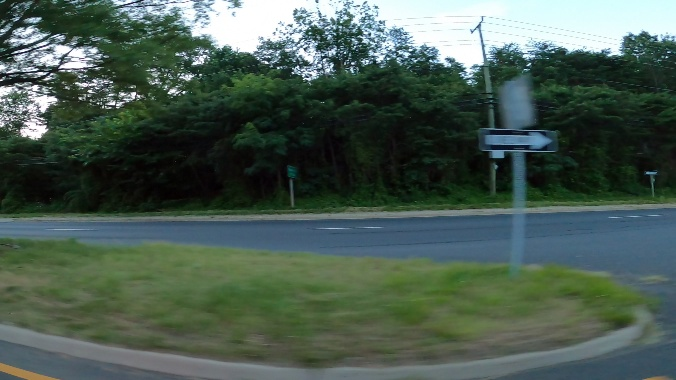

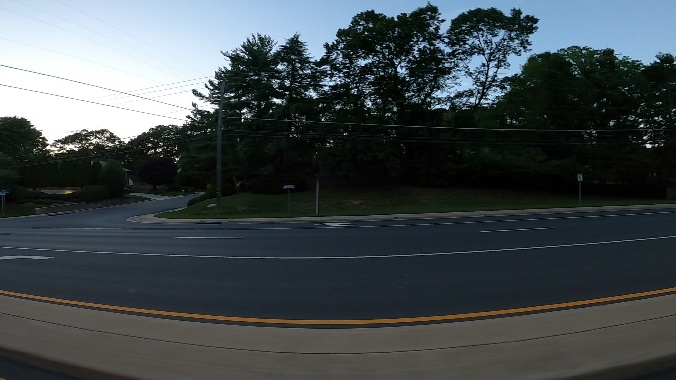

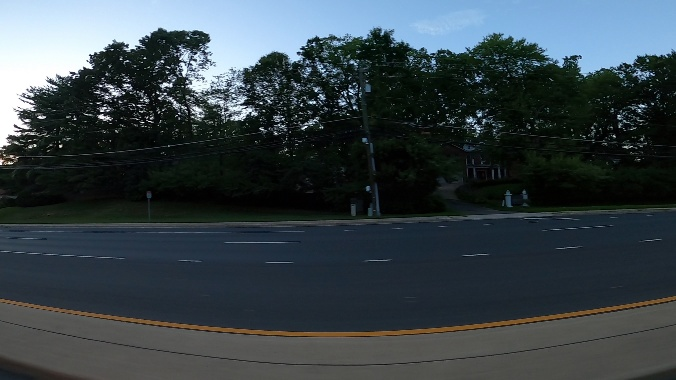

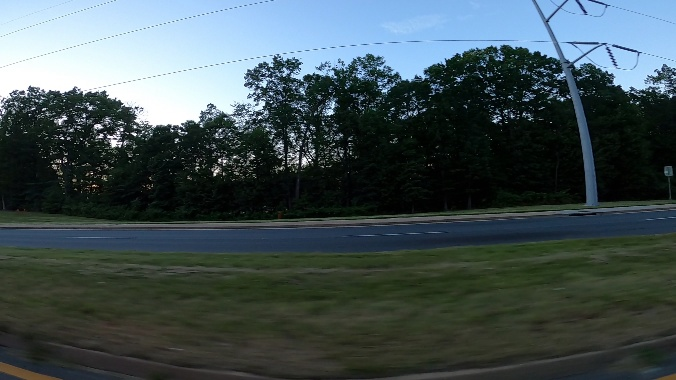

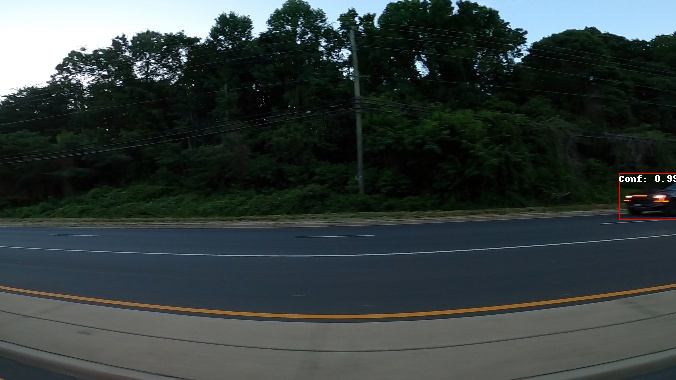

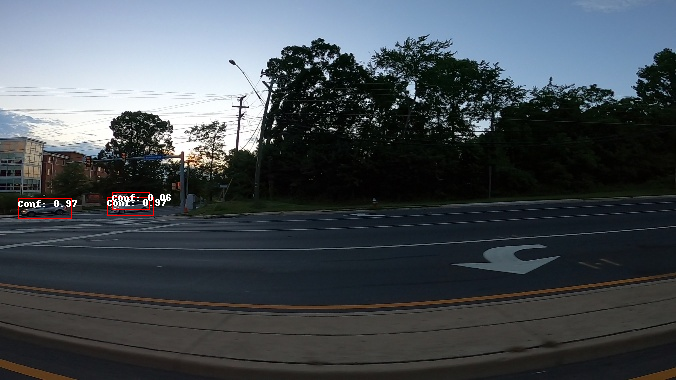

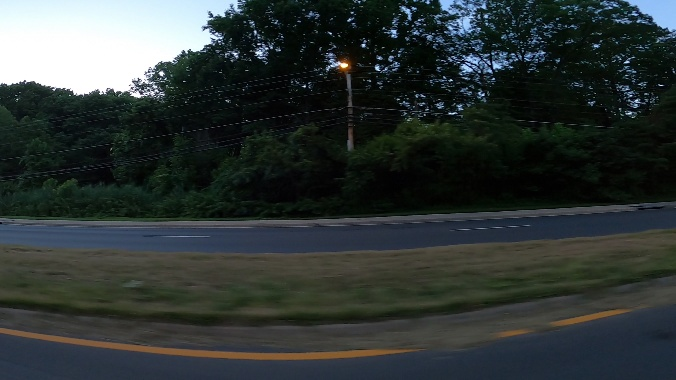

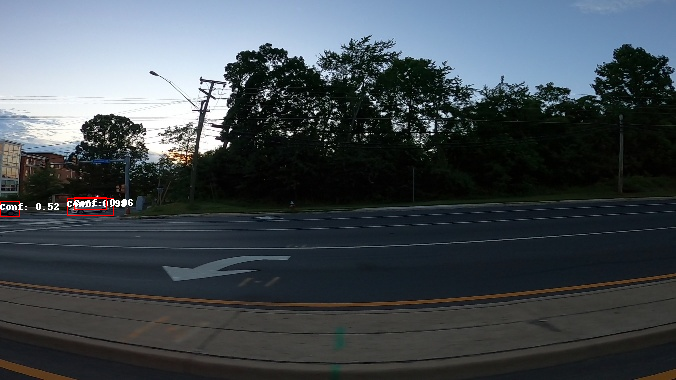

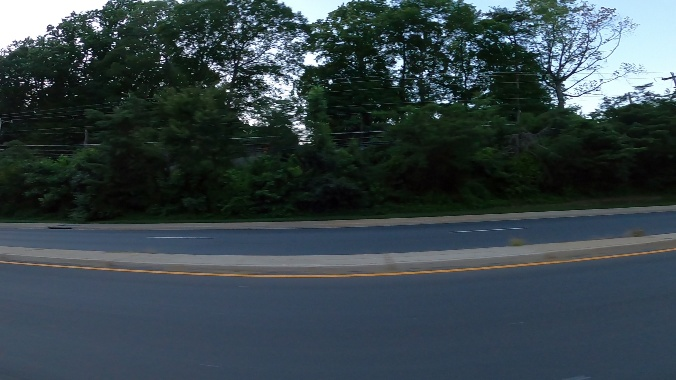

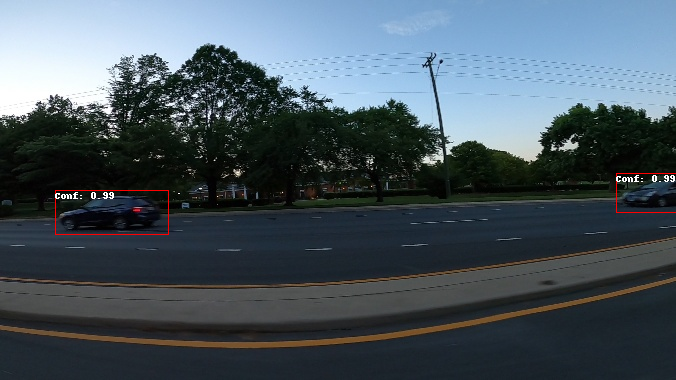

In [28]:
np.random.shuffle(test_imgs)
disp_test_imgs(test_imgs[:10])

In [65]:
def visualize_batch(model, train_loader, device):
    model.eval()
    with torch.no_grad():
        for data in train_loader:
            imgs = list(d[0].to(device) for d in data)
            targets = [{k: v.to(device) for k, v in d[1].items()} for d in data]

            for img, target in zip(imgs, targets):
                output = model([img])
                out_bbox = output[0]["boxes"]
                out_scores = output[0]["scores"]

                keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)

                im = (img.permute(1, 2, 0).cpu().numpy() * 255).astype('uint8')
                vtest = Image.fromarray(im)
                draw = ImageDraw.Draw(vtest)

                for box, score in zip(out_bbox[keep], out_scores[keep]):
                    draw.rectangle(list(box.cpu().numpy()), outline="red")
                    draw.text((box[0].item(), box[1].item()), f"Conf: {score:.2f}", fill="red")

                gt_boxes = target['boxes']
                for box in gt_boxes:
                    draw.rectangle(list(box.cpu().numpy()), outline="green")

                display(vtest)

            break 

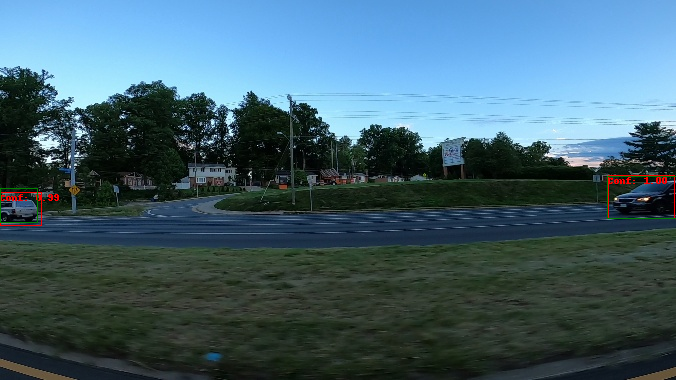

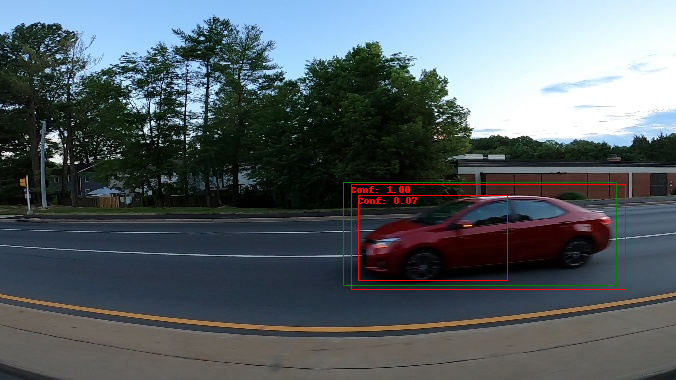

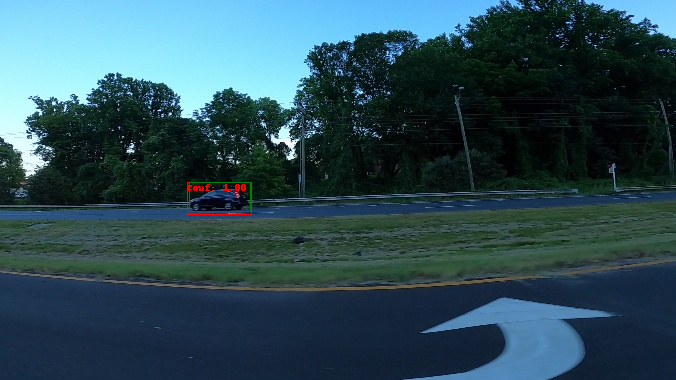

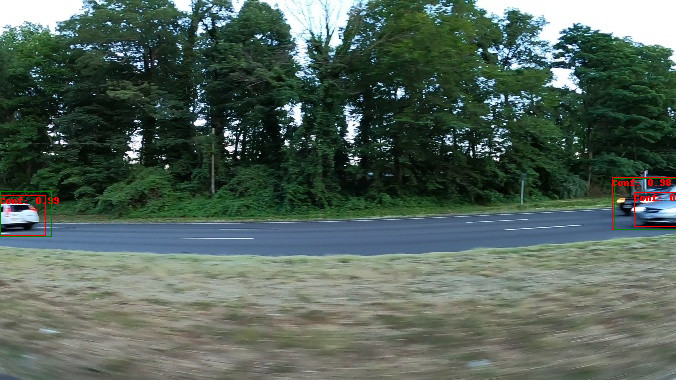

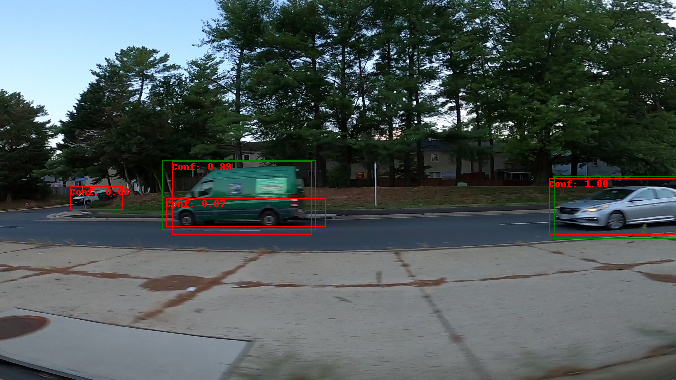

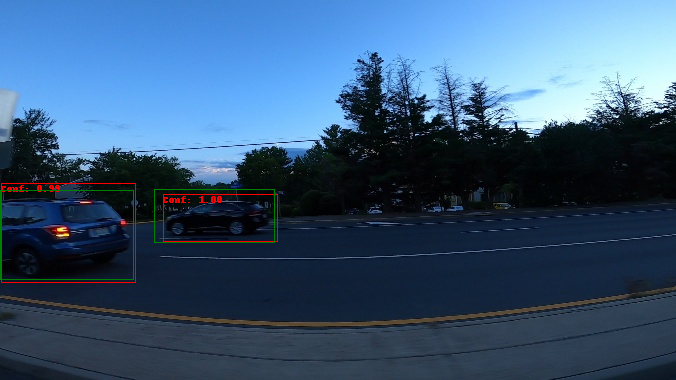

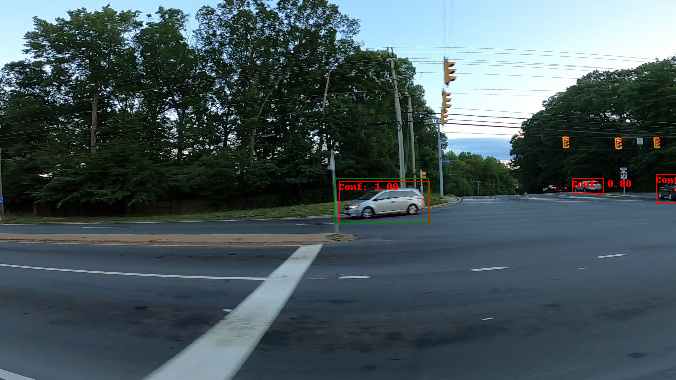

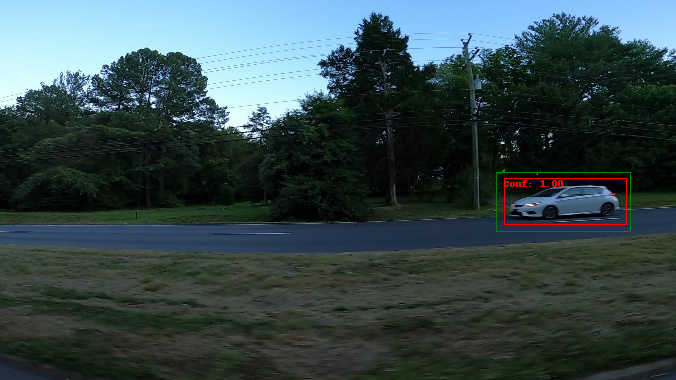

In [66]:
visualize_batch(model, train_dl, device='cuda')

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
import numpy as np
import torch
import torchvision

def calculate_metrics(model, data_loader, device, conf_threshold=0.5):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data in data_loader:
            for img, target in data:
                img = img.to(device)
                true_boxes = target['boxes'].to(device)
                true_labels = target['labels'].to(device)

                output = model([img])

                pred_boxes = output[0]['boxes'].to(device)
                pred_scores = output[0]['scores'].to(device)
                pred_labels = output[0]['labels'].to(device)

                keep = pred_scores > conf_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                matched_gt = torch.zeros(len(true_boxes), dtype=torch.bool, device=device)
                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    iou = torchvision.ops.box_iou(pred_box.unsqueeze(0), true_boxes)
                    max_iou, max_idx = iou.max(dim=1)
                    if max_iou > 0.5 and not matched_gt[max_idx]:
                        matched_gt[max_idx] = True
                        all_targets.append(true_labels[max_idx].cpu().item())
                        all_predictions.append(pred_label.cpu().item())

                for gt_label, matched in zip(true_labels, matched_gt):
                    if not matched:
                        all_targets.append(gt_label.cpu().item())
                        all_predictions.append(0)

    cm = confusion_matrix(all_targets, all_predictions)
    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    precision = precision_score(all_targets, all_predictions, average='weighted')

    return cm, accuracy, f1, precision

cm, accuracy, f1, precision = calculate_metrics(model, train_dl, device)

print("Confusion Matrix:")
print(cm.T)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")

Confusion Matrix:
[[  0   2]
 [  0 501]]
Accuracy: 0.9960
F1 Score: 0.9980
Precision: 1.0000


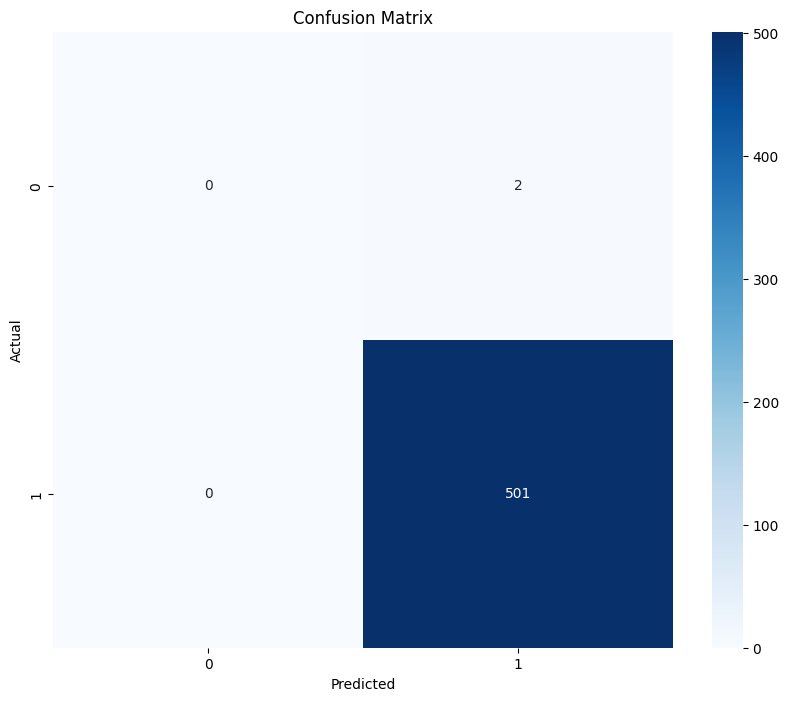

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()